# Issue Commit Classification - DiD (Document 2)

## 1. Import Train/Test Data & Concatenate files to one df

In [1]:
import pandas as pd
import json
import gzip
import io
import time
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import requests
import os
import sys
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

D:\Anaconda\envs\mlcourse\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from sklearn.metrics import classification_report
import torch.nn as nn
import optuna
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

D:\Anaconda\envs\mlcourse\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
access_token = config.ACCESS_TOKEN
github_token = config.GITHUB_TOKEN

In [4]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2022, 4, 1, 15)  # year, month, day, hour
end = datetime(2022, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2022-04-01-15.json.gz. No need to download.
The file already exists at data\2022-04-01-16.json.gz. No need to download.
The file already exists at data\2022-04-01-17.json.gz. No need to download.
The file already exists at data\2022-04-01-18.json.gz. No need to download.


In [5]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2023, 4, 1, 15)  # year, month, day, hour
end = datetime(2023, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2023-04-01-15.json.gz. No need to download.
The file already exists at data\2023-04-01-16.json.gz. No need to download.
The file already exists at data\2023-04-01-17.json.gz. No need to download.
The file already exists at data\2023-04-01-18.json.gz. No need to download.


In [6]:
file_names = [
    '2022-04-01-15.json.gz', 
    '2022-04-01-16.json.gz',
    '2022-04-01-17.json.gz',
    '2022-04-01-18.json.gz',
    '2023-04-01-15.json.gz', 
    '2023-04-01-16.json.gz',
    '2023-04-01-17.json.gz',
    '2023-04-01-18.json.gz',
]
all_data = [] 
def process_file(file_path):
    data_list = []    
    with gzip.open(file_path, 'r') as f:
        for line in f:
            if isinstance(line, bytes):
                line = line.decode('utf-8')
            data = json.loads(line)
            data_list.append(data)
    df = pd.DataFrame(data_list)
    return df
# Process each file
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    print(f"Processing file: {file_path}")
    current_df = process_file(file_path)
    all_data.append(current_df) 

# Concatenate all the data into a single DataFrame
first_df = pd.concat(all_data, ignore_index=True)
print("All files have been processed and combined.")

Processing file: data\2022-04-01-15.json.gz
Processing file: data\2022-04-01-16.json.gz
Processing file: data\2022-04-01-17.json.gz
Processing file: data\2022-04-01-18.json.gz
Processing file: data\2023-04-01-15.json.gz
Processing file: data\2023-04-01-16.json.gz
Processing file: data\2023-04-01-17.json.gz
Processing file: data\2023-04-01-18.json.gz
All files have been processed and combined.


In [7]:
first_df.head()

,id,type,actor,repo,payload,public,created_at,org
0,21067017389,PushEvent,"{'id': 101735524, 'login': 'rashel9454', 'disp...","{'id': 475677195, 'name': 'rashel9454/class3as...","{'push_id': 9513331909, 'size': 1, 'distinct_s...",True,2022-04-01T15:00:00Z,NaN
1,21067017424,PushEvent,"{'id': 60771195, 'login': 'Avinaw', 'display_l...","{'id': 259306531, 'name': 'Avinaw/docker-alpin...","{'push_id': 9513331853, 'size': 1, 'distinct_s...",True,2022-04-01T15:00:00Z,NaN
2,21067017426,CreateEvent,"{'id': 3775910, 'login': 'v-rudkovskiy', 'disp...","{'id': 99856885, 'name': 'Labs64/NetLicensingC...","{'ref': 'RVA_NLIC-2368_fix_vulnerability', 're...",True,2022-04-01T15:00:00Z,"{'id': 1461983, 'login': 'Labs64', 'gravatar_i..."
3,21067017428,DeleteEvent,"{'id': 30536864, 'login': 'signcla-test-signed...","{'id': 409344435, 'name': 'google-test2/signcl...",{'ref': 'v2-signcla-prober-2-45b6ad45-4c42-4da...,True,2022-04-01T15:00:00Z,"{'id': 9579519, 'login': 'google-test2', 'grav..."
4,21067017438,PushEvent,"{'id': 3743002, 'login': 'mrz1836', 'display_l...","{'id': 457427881, 'name': 'BuxOrg/bux', 'url':...","{'push_id': 9513331895, 'size': 1, 'distinct_s...",True,2022-04-01T15:00:00Z,"{'id': 98559231, 'login': 'BuxOrg', 'gravatar_..."


In [8]:
first_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285782 entries, 0 to 1285781
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   id          1285782 non-null  object
 1   type        1285782 non-null  object
 2   actor       1285782 non-null  object
 3   repo        1285782 non-null  object
 4   payload     1285782 non-null  object
 5   public      1285782 non-null  bool  
 6   created_at  1285782 non-null  object
 7   org         344277 non-null   object
dtypes: bool(1), object(7)
memory usage: 69.9+ MB


# 2. First Data Preparation - IssueEvents and data extraction

In [9]:
first_subset = first_df[first_df['type'] == 'IssuesEvent']
first_subset = first_subset.reset_index(drop=True)

In [12]:
second_df = pd.DataFrame(columns=['url', 'repo', 'title', 'body', 'num_labels', 'labels', 'c_bug', 'c_feature', 'c_question', 'class_int', 'created_at', 'org', 'actor'])

In [13]:
new_data = []

for index, row in first_subset.iterrows():
    if 'issue' in row['payload']:
        url = row['payload']['issue']['html_url']
        created_at = row['created_at']
        repo = row['repo']['name']
        actor = row['actor']
        org = row['org']
        title = row['payload']['issue']['title']
        body = row['payload']['issue']['body']
        num_labels = len(row['payload']['issue']['labels'])
        labels = [label['name'] for label in row['payload']['issue']['labels']]
        
        # Define class_int based on label presence
        if 'bug' in labels:
            class_int = 0
        elif any(label in ['feature', 'enhancement', 'improvement', 'request'] for label in labels):
            class_int = 1
        elif any(label in ['question', 'discussion'] for label in labels):
            class_int = 2
        else:
            class_int = -1  # Handle cases where no class label is found
        
        # Append the extracted data as a dictionary
        new_data.append({
            'url': url,
            'repo': repo,
            'actor': actor,
            'org': org,
            'created_at': created_at,
            'title': title,
            'body': body,
            'num_labels': num_labels,
            'labels': labels,  # Store all labels for each issue as a list
            'class_int': class_int
        })

# Create the new DataFrame using pandas.concat
second_df = pd.DataFrame(new_data)

In [14]:
second_df

,url,repo,actor,org,created_at,title,body,num_labels,labels,class_int
0,https://github.com/avaframe/AvaFrame/issues/708,avaframe/AvaFrame,"{'id': 70522571, 'login': 'jtfisch', 'display_...","{'id': 68648473, 'login': 'avaframe', 'gravata...",2022-04-01T15:00:00Z,add comXmaxvelocity and comYvoellmyaval1d,None,0,[],-1
1,https://github.com/idsb3t1/WebIDE-UISimpleTC-2...,idsb3t1/WebIDE-UISimpleTC-2022-04-01T14-55-30....,"{'id': 18148588, 'login': 'idsb3t1', 'display_...",NaN,2022-04-01T15:00:00Z,Update deployed app page,New contents needed !,0,[],-1
2,https://github.com/eclipse/org.aspectj/issues/148,eclipse/org.aspectj,"{'id': 1537384, 'login': 'kriegaex', 'display_...","{'id': 56974, 'login': 'eclipse', 'gravatar_id...",2022-04-01T15:00:00Z,Renovate or remove AspectJ Browser,Maybe the AspectJ Browser is or used to be a h...,0,[],-1
3,https://github.com/mozilla/experimenter/issues...,mozilla/experimenter,"{'id': 102263964, 'login': 'mikewilli', 'displ...","{'id': 131524, 'login': 'mozilla', 'gravatar_i...",2022-04-01T15:00:01Z,"Update README: Starting Nimbus UI, Linux setup...",Adding some notes to the README after setting ...,0,[],-1
4,https://github.com/svennijhuis/Blok-Tech-Gamin...,svennijhuis/Blok-Tech-GamingBuddy,"{'id': 94171125, 'login': 'ArisRosbach', 'disp...",NaN,2022-04-01T15:00:01Z,Gezamelijke stijl voor filteren en chat,Er moet een universele stijl komen voor de fil...,0,[],-1
...,...,...,...,...,...,...,...,...,...,...
29691,https://github.com/AdguardTeam/AdguardFilters/...,AdguardTeam/AdguardFilters,"{'id': 30082422, 'login': 'adguard-bot', 'disp...","{'id': 8361145, 'login': 'AdguardTeam', 'grava...",2023-04-01T18:59:56Z,www.lanacion.com.ar,\r\n### Issue URL (Ads)\r\n [https://www.lanac...,3,"[T: Ads, P4: Low, N: AdGuard Browser Extension]",-1
29692,https://github.com/cjgomer/Warno/issues/7,cjgomer/Warno,"{'id': 44076257, 'login': 'cjgomer', 'display_...",NaN,2023-04-01T18:59:58Z,Divison Slot Matrix,None,0,[],-1
29693,https://github.com/AY2223S2-CS2103-F10-2/tp/is...,AY2223S2-CS2103-F10-2/tp,"{'id': 98014932, 'login': 'lennoxtr', 'display...","{'id': 125197182, 'login': 'AY2223S2-CS2103-F1...",2023-04-01T18:59:58Z,Update Use Cases of Import Command in Develope...,None,1,[priority.High],-1
29694,https://github.com/akkabb/blog_php_oc/issues/3,akkabb/blog_php_oc,"{'id': 109074475, 'login': 'akkabb', 'display_...",NaN,2023-04-01T18:59:59Z,Init Model,Create : \r\n\r\n- [ ] import.sql\r\n- [ ] dat...,0,[],-1


In [15]:
second_df.groupby('class_int').size()

class_int
-1    25944
 0     1882
 1     1665
 2      205
dtype: int64

# 3. Train/Test Split and TextProcessing

In [16]:
third_df = second_df[second_df['class_int'] != -1]

In [21]:
third_df.groupby('class_int').size()

class_int
0    1882
1    1665
2     205
dtype: int64

In [22]:
third_df['text'] = third_df['title'] + ' ' + third_df['body']

# Encode the 'class_int' labels
label_encoder = LabelEncoder()
third_df['class_int'] = label_encoder.fit_transform(third_df['class_int'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(third_df, test_size=0.2, random_state=42)

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\2507417196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_df['text'] = third_df['title'] + ' ' + third_df['body']
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\2507417196.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_df['class_int'] = label_encoder.fit_transform(third_df['class_int'])


In [23]:
# Initialize the BERT tokenizer
tokenizer_f1 = BertTokenizer.from_pretrained('bert-base-uncased')

In [24]:
# Define a custom dataset
class TextClassificationDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=True,
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(labels, dtype=torch.long),
        }

In [25]:
train_dataset = TextClassificationDataset(
    text=train_df['text'].values,  # Assuming 'text' is the column name for text data
    labels=train_df['class_int'].values,  # Assuming 'labels' is the column name for labels
    tokenizer=tokenizer_f1,  # You need to initialize your tokenizer
    max_length= 128
)

In [26]:
test_dataset = TextClassificationDataset(
    text=test_df['text'].values,  # Assuming 'text' is the column name for text data
    labels=test_df['class_int'].values,  # Assuming 'labels' is the column name for labels
    tokenizer=tokenizer_f1,  # You need to initialize your tokenizer
    max_length= 128
)

In [27]:
train_loader = DataLoader(train_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, shuffle=False)

# 4. Model Training with best hyperparameters from document 1

In [28]:
true_labels = []
predictions = []

In [29]:
# Define a function to train and evaluate a model with specific hyperparameters
def train_and_evaluate(learning_rate, batch_size, num_epochs):
    # Initialize the model and optimizer with the provided hyperparameters
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation
    model.eval()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_labels = np.argmax(logits.cpu().numpy(), axis=1)

            predictions.extend(predicted_labels)
            true_labels.extend(labels)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    return model, accuracy

# Load the best hyperparameters from the Optuna study
best_learning_rate = 1.2601205991776913e-05
best_batch_size = 32
best_num_epochs = 9

# Train and evaluate the model with the best hyperparameters
best_model, best_accuracy = train_and_evaluate(best_learning_rate, best_batch_size, best_num_epochs)

# Save the best model checkpoint
torch.save(best_model.state_dict(), 'best_model.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Anaconda\envs\mlcourse\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
# Get the classification report
class_report = classification_report(true_labels, predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       375
           1       0.80      0.89      0.84       335
           2       0.64      0.51      0.57        41

    accuracy                           0.84       751
   macro avg       0.78      0.74      0.76       751
weighted avg       0.84      0.84      0.83       751



# 5. Applying the model to the data we want to analyse

In [31]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2022, 4, 2, 15)  # year, month, day, hour
end = datetime(2022, 4, 2, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

File downloaded successfully and saved to data\2022-04-02-15.json.gz
File downloaded successfully and saved to data\2022-04-02-16.json.gz
File downloaded successfully and saved to data\2022-04-02-17.json.gz
File downloaded successfully and saved to data\2022-04-02-18.json.gz


In [34]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2023, 4, 2, 15)  # year, month, day, hour
end = datetime(2023, 4, 2, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2023-04-02-15.json.gz. No need to download.
The file already exists at data\2023-04-02-16.json.gz. No need to download.
The file already exists at data\2023-04-02-17.json.gz. No need to download.
The file already exists at data\2023-04-02-18.json.gz. No need to download.


In [35]:
file_names = [
    '2022-04-02-15.json.gz', 
    '2022-04-02-16.json.gz',
    '2022-04-02-17.json.gz',
    '2022-04-02-18.json.gz',
    '2023-04-02-15.json.gz', 
    '2023-04-02-16.json.gz',
    '2023-04-02-17.json.gz',
    '2023-04-02-18.json.gz',
]
all_data = [] 
def process_file(file_path):
    data_list = []    
    with gzip.open(file_path, 'r') as f:
        for line in f:
            if isinstance(line, bytes):
                line = line.decode('utf-8')
            data = json.loads(line)
            data_list.append(data)
    df = pd.DataFrame(data_list)
    return df
# Process each file
for file_name in file_names:
    file_path = os.path.join('data', file_name)
    
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    print(f"Processing file: {file_path}")
    current_df = process_file(file_path)
    all_data.append(current_df) 

# Concatenate all the data into a single DataFrame
temporary_df = pd.concat(all_data, ignore_index=True)
print("All files have been processed and combined.")

Processing file: data\2022-04-02-15.json.gz
Processing file: data\2022-04-02-16.json.gz
Processing file: data\2022-04-02-17.json.gz
Processing file: data\2022-04-02-18.json.gz
Processing file: data\2023-04-02-15.json.gz
Processing file: data\2023-04-02-16.json.gz
Processing file: data\2023-04-02-17.json.gz
Processing file: data\2023-04-02-18.json.gz
All files have been processed and combined.


In [36]:
analysis_subset = temporary_df[temporary_df['type'] == 'IssuesEvent']
analysis_subset = analysis_subset.reset_index(drop=True)

In [37]:
analysis_df = pd.DataFrame(columns=['url', 'repo', 'title', 'body', 'num_labels', 'labels', 'c_bug', 'c_feature', 'c_question', 'class_int', 'created_at', 'org', 'actor'])

In [39]:
new_data = []

for index, row in analysis_subset.iterrows():
    if 'issue' in row['payload']:
        url = row['payload']['issue']['html_url']
        created_at = row['created_at']
        repo = row['repo']['name']
        actor = row['actor']
        org = row['org']
        title = row['payload']['issue']['title']
        body = row['payload']['issue']['body']
        num_labels = len(row['payload']['issue']['labels'])
        labels = [label['name'] for label in row['payload']['issue']['labels']]
        
        # Define class_int based on label presence
        if 'bug' in labels:
            class_int = 0
        elif any(label in ['feature', 'enhancement', 'improvement', 'request'] for label in labels):
            class_int = 1
        elif any(label in ['question', 'discussion'] for label in labels):
            class_int = 2
        else:
            class_int = -1  # Handle cases where no class label is found
        
        # Append the extracted data as a dictionary
        new_data.append({
            'url': url,
            'repo': repo,
            'actor': actor,
            'org': org,
            'created_at': created_at,
            'title': title,
            'body': body,
            'num_labels': num_labels,
            'labels': labels,  # Store all labels for each issue as a list
            'class_int': class_int
        })

# Create the new DataFrame using pandas.concat
analysis_df = pd.DataFrame(new_data)

## 5.1 Applying the model only to unlabeled commits

In [40]:
analysis_labeled = analysis_df[analysis_df['class_int'] != -1]

In [41]:
analysis_unlabeled = analysis_df[analysis_df['class_int'] == -1]

In [42]:
analysis_unlabeled['text'] = analysis_unlabeled['title'] + ' ' + analysis_unlabeled['body']

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\1016003833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_unlabeled['text'] = analysis_unlabeled['title'] + ' ' + analysis_unlabeled['body']


In [43]:
class TextClassificationDataset(Dataset):
    def __init__(self, text, labels, tokenizer, max_length):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = str(self.text[idx])
        labels = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            return_token_type_ids=False,
            return_attention_mask=True,
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(labels, dtype=torch.long),
        }

In [44]:
# Create DataLoader for prediction (use your dataset class)
prediction_dataset = TextClassificationDataset(
    analysis_unlabeled['text'].values,
    analysis_unlabeled['class_int'].values,  # You can keep the original labels for comparison
    tokenizer = tokenizer_f1,
    max_length = 128,
)

prediction_loader = DataLoader(prediction_dataset, batch_size=8, shuffle=False)

In [45]:
# Initialize lists to store predicted labels
predicted_labels = []

In [46]:
# Set the model to evaluation mode
best_model.eval()

# Make predictions
with torch.no_grad():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    for batch in prediction_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = best_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_batch = torch.argmax(logits, dim=1).cpu().numpy()
        predicted_labels.extend(predicted_labels_batch)

# Update the 'class_int' column in your dataset with the predicted labels
analysis_unlabeled['class_int'] = predicted_labels

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\1797748974.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_unlabeled['class_int'] = predicted_labels


In [47]:
final_df = pd.concat([analysis_unlabeled, analysis_labeled], axis=0, ignore_index=True)

In [48]:
final_df

,url,repo,actor,org,created_at,title,body,num_labels,labels,class_int,text
0,https://github.com/saadeghi/daisyui/issues/682,saadeghi/daisyui,"{'id': 7342023, 'login': 'saadeghi', 'display_...",NaN,2022-04-02T15:00:02Z,Label is clickable with checkbox,Normally if you use checkbox you can click any...,0,[],1,Label is clickable with checkbox Normally if y...
1,https://github.com/bvenkysubbu/tymlymonitor/is...,bvenkysubbu/tymlymonitor,"{'id': 10861600, 'login': 'bvenkysubbu', 'disp...",NaN,2022-04-02T15:00:03Z,🛑 SMR Vinay Cascade B Block is down,In [`1a04616`](https://github.com/bvenkysubbu/...,2,"[status, smr-vinay-cascade-b-block]",0,🛑 SMR Vinay Cascade B Block is down In [`1a046...
2,https://github.com/shwe24/Aspect-Based-Sentime...,shwe24/Aspect-Based-Sentiment-Classification,"{'id': 88274449, 'login': 'prashantprithak', '...",NaN,2022-04-02T15:00:03Z,It is showing this error.,![image](https://user-images.githubusercontent...,0,[],0,It is showing this error. ![image](https://use...
3,https://github.com/siyuan-note/siyuan/issues/4473,siyuan-note/siyuan,"{'id': 970828, 'login': 'Vanessa219', 'display...","{'id': 70468694, 'login': 'siyuan-note', 'grav...",2022-04-02T15:00:05Z,划选多块撤销后没有充分还原,![issue](https://user-images.githubusercontent...,1,[Bug],0,划选多块撤销后没有充分还原 ![issue](https://user-images.git...
4,https://github.com/claytonplong/backup-uptime/...,claytonplong/backup-uptime,"{'id': 4020307, 'login': 'claytonplong', 'disp...",NaN,2022-04-02T15:00:08Z,🛑 livevault is down,In [`9783df7`](https://github.com/claytonplong...,2,"[status, livevault]",0,🛑 livevault is down In [`9783df7`](https://git...
...,...,...,...,...,...,...,...,...,...,...,...
24565,https://github.com/detekt/detekt/issues/5900,detekt/detekt,"{'id': 30376729, 'login': 'schalkms', 'display...","{'id': 57960713, 'login': 'detekt', 'gravatar_...",2023-04-02T18:59:09Z,Website search does not work when embedding th...,## Expected Behavior\r\nI would like to browse...,1,[discussion],2,NaN
24566,https://github.com/WSU-4110/Giftly/issues/81,WSU-4110/Giftly,"{'id': 81935916, 'login': 'plazluis', 'display...","{'id': 55041847, 'login': 'WSU-4110', 'gravata...",2023-04-02T18:59:35Z,Sign in bug,None,1,[bug],0,NaN
24567,https://github.com/jaemyeong/GitHub/issues/26,jaemyeong/GitHub,"{'id': 681092, 'login': 'jaemyeong', 'display_...",NaN,2023-04-02T18:59:40Z,Main 스토리보드 제거,None,1,[enhancement],1,NaN
24568,https://github.com/TsonevIliyan/Freelancing/is...,TsonevIliyan/Freelancing,"{'id': 124197489, 'login': 'TsonevIliyan', 'di...",NaN,2023-04-02T18:59:46Z,At Footer section [Insurance & Assistance] cli...,Test Objective: Looking for bugs while doing e...,1,[bug],0,NaN


In [49]:
final_df.groupby('class_int').size()

class_int
0    11799
1    11262
2     1509
dtype: int64

# 6. DiD Data Preprocessing

In [53]:
commits = final_df
# add time_id
commits['created_at'] = pd.to_datetime(commits['created_at'])
commits['time_id'] = commits['created_at'].dt.strftime('%d.%m.%Y, %H:00')

# Function to determine 'pre' or 'post' based on the year in 'time_id' and creating the column 'gpt' accordingly
def determine_gpt(time_str):
    year = time_str.split('.')[-1].split(',')[0]  # Extracting the year part from the 'time_id'
    if year == '2022':
        return 'pre'
    elif year == '2023':
        return 'post'
    else:
        return None
    
commits['period'] = commits['time_id'].apply(determine_gpt)

commits['Treatment'] = np.random.randint(2, size=len(commits))

# Selecting necessary columns to form the final panel data
if 'actor' in commits.columns:
    commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
# Extracting 'name' from the nested 'repo' dictionary (similar to 'actor_login')
if 'repo' in commits.columns:
    commits['repo_name'] = commits['repo']
    
panel_data_columns = ['time_id', 'period', 'Treatment', 'class_int', 'actor_login', 'repo_name']  # Adjusted columns
panel_data = commits[panel_data_columns]
panel_data.head()

,time_id,period,Treatment,class_int,actor_login,repo_name
0,"02.04.2022, 15:00",pre,1,1,saadeghi,saadeghi/daisyui
1,"02.04.2022, 15:00",pre,0,0,bvenkysubbu,bvenkysubbu/tymlymonitor
2,"02.04.2022, 15:00",pre,0,0,prashantprithak,shwe24/Aspect-Based-Sentiment-Classification
3,"02.04.2022, 15:00",pre,1,0,Vanessa219,siyuan-note/siyuan
4,"02.04.2022, 15:00",pre,0,0,claytonplong,claytonplong/backup-uptime


In [54]:
#check number of unique timestamps
panel = panel_data
panel_data['time_id'].value_counts()

02.04.2023, 16:00    3911
02.04.2023, 15:00    3574
02.04.2023, 18:00    3067
02.04.2023, 17:00    3020
02.04.2022, 17:00    2990
02.04.2022, 15:00    2912
02.04.2022, 16:00    2673
02.04.2022, 18:00    2423
Name: time_id, dtype: int64

C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\754469785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['time_id'] = pd.to_datetime(panel_data['time_id'], format='%d.%m.%Y, %H:%M')
C:\Users\Guilherme\AppData\Local\Temp\ipykernel_4904\754469785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_data['time_id'] = panel_data['time_id'].dt.strftime('%d.%m.%Y, %H:%M')


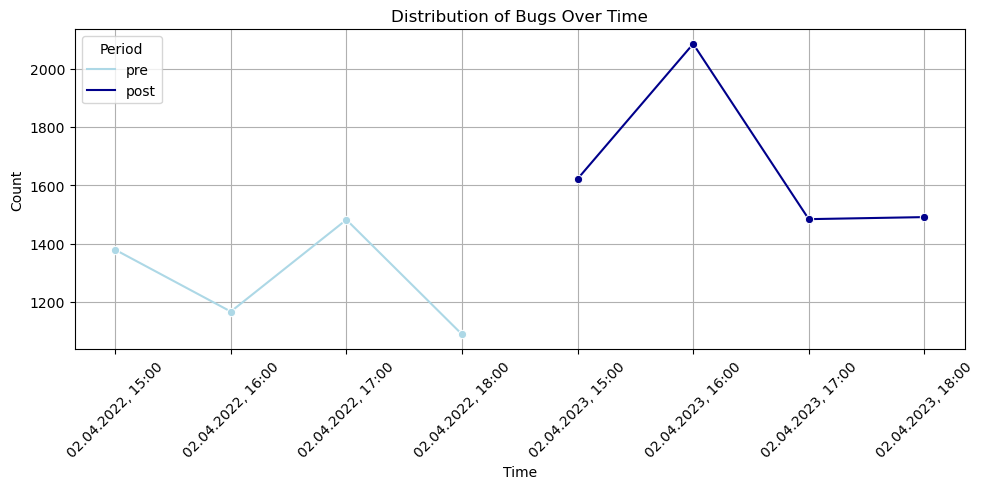

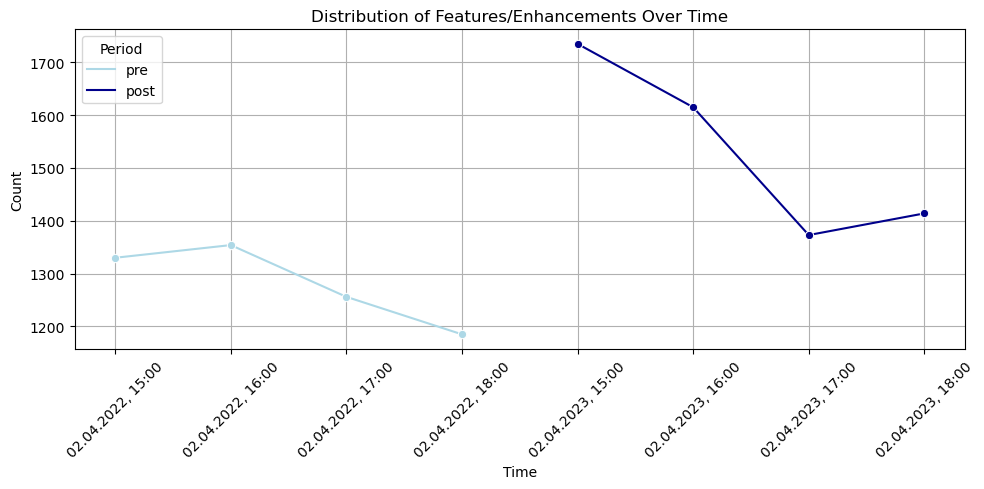

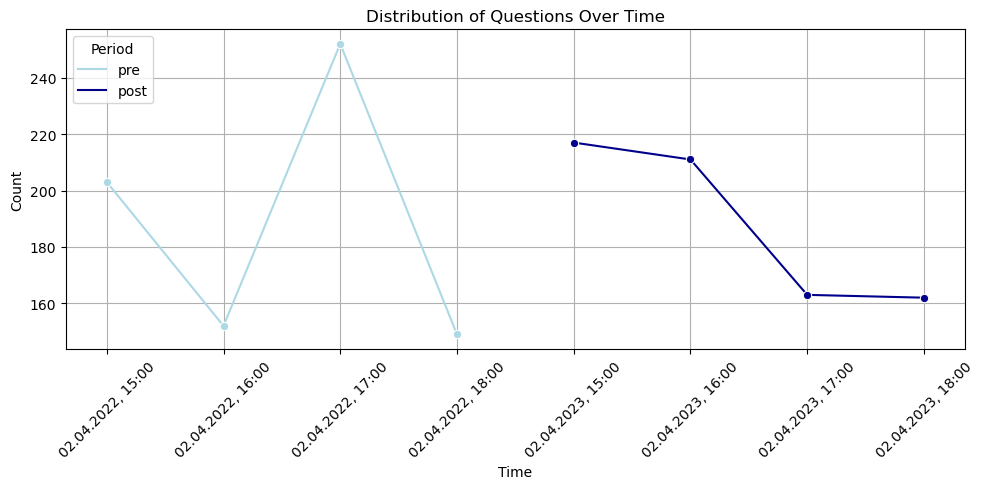

In [55]:
# Check if 'time_id' is not of datetime dtype and convert if necessary
if not pd.api.types.is_datetime64_any_dtype(panel_data['time_id']):
    panel_data['time_id'] = pd.to_datetime(panel_data['time_id'], format='%d.%m.%Y, %H:%M')
panel_data['time_id'] = panel_data['time_id'].dt.strftime('%d.%m.%Y, %H:%M')

# Creating a copy might be necessary to avoid warnings, but if it's not needed, you can remove this line.
panel_data = panel_data.copy()

# Create a mapping for class_int values to labels
class_labels = {0: 'bug', 1: 'feature/enhancement', 2: 'question'}

# Map class_int values to labels in your dataset
panel_data['class_label'] = panel_data['class_int'].map(class_labels)

# Group the data by 'time_id' and 'period' and calculate the distribution of each class
grouped = panel_data.groupby(['time_id', 'period', 'class_label']).size().unstack(fill_value=0)
grouped.reset_index(inplace=True)

titles = ['Distribution of Bugs Over Time', 'Distribution of Features/Enhancements Over Time', 'Distribution of Questions Over Time']

for class_label, title in zip(class_labels.values(), titles):
    plt.figure(figsize=(10, 5))

    # Plotting lines for 'pre' and 'post' separately
    sns.lineplot(
        x='time_id', y=class_label, hue='period',
        palette={'pre': 'lightblue', 'post': 'darkblue'},  # Assigning colors
        marker='o',
        data=grouped,
        sort=False
    )
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Period', loc='upper left')  # Adding a legend to differentiate 'pre' and 'post'
    plt.show()

# Setting up the DiD Framework

### Creating Interaction Term (between 'period' and 'Treatment' variables) catching the treatment effect

In [56]:
# Create a copy of the dataframe to avoid SettingWithCopyWarning
panel = panel.copy()

# Convert 'time_id' to datetime, 'period' to numerical, ensure 'Treatment' is of type int
panel['time_id'] = pd.to_datetime(panel['time_id'], format='%d.%m.%Y, %H:%M')
panel['period'] = panel['period'].replace({'pre': 0, 'post': 1}).astype(int)
panel['Treatment'] = panel['Treatment'].replace({0: 0, 1: 1}).astype(int)
print(panel[['Treatment', 'period']].dtypes)

# Create the interaction term
panel['treat_period'] = panel['Treatment'] * panel['period']

# For the regression, it's better to have numerical variables, so converting the booleans to int based on 'class_int'
for class_int in range(3):
    class_col = f'class_int_{class_int}'
    panel[class_col] = (panel['class_int'] == class_int).astype(int)

# Now, you have columns like 'class_int_0', 'class_int_1', 'class_int_2' with 1 indicating the presence of the class and 0 for others

Treatment    int32
period       int32
dtype: object


In [58]:
# Drop the 'class_int' column inplace
panel.drop(columns=['class_int'], inplace=True)

In [59]:
panel.head()

,time_id,period,Treatment,actor_login,repo_name,treat_period,class_int_0,class_int_1,class_int_2
0,2022-04-02 15:00:00,0,1,saadeghi,saadeghi/daisyui,0,0,1,0
1,2022-04-02 15:00:00,0,0,bvenkysubbu,bvenkysubbu/tymlymonitor,0,1,0,0
2,2022-04-02 15:00:00,0,0,prashantprithak,shwe24/Aspect-Based-Sentiment-Classification,0,1,0,0
3,2022-04-02 15:00:00,0,1,Vanessa219,siyuan-note/siyuan,0,1,0,0
4,2022-04-02 15:00:00,0,0,claytonplong,claytonplong/backup-uptime,0,1,0,0


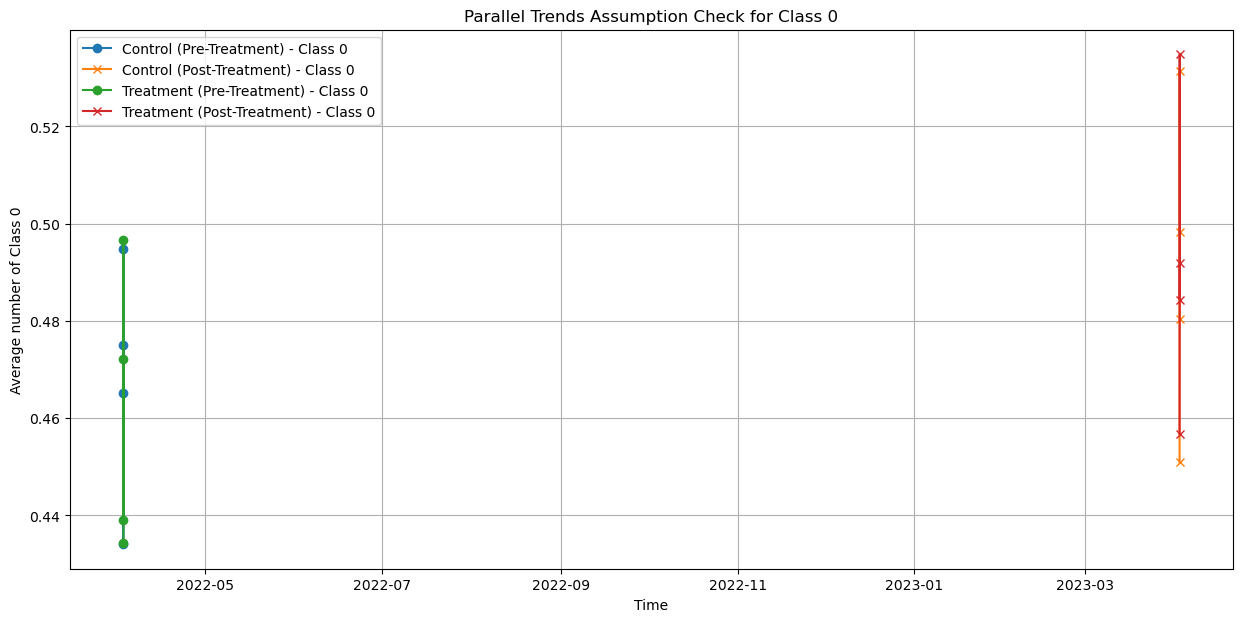

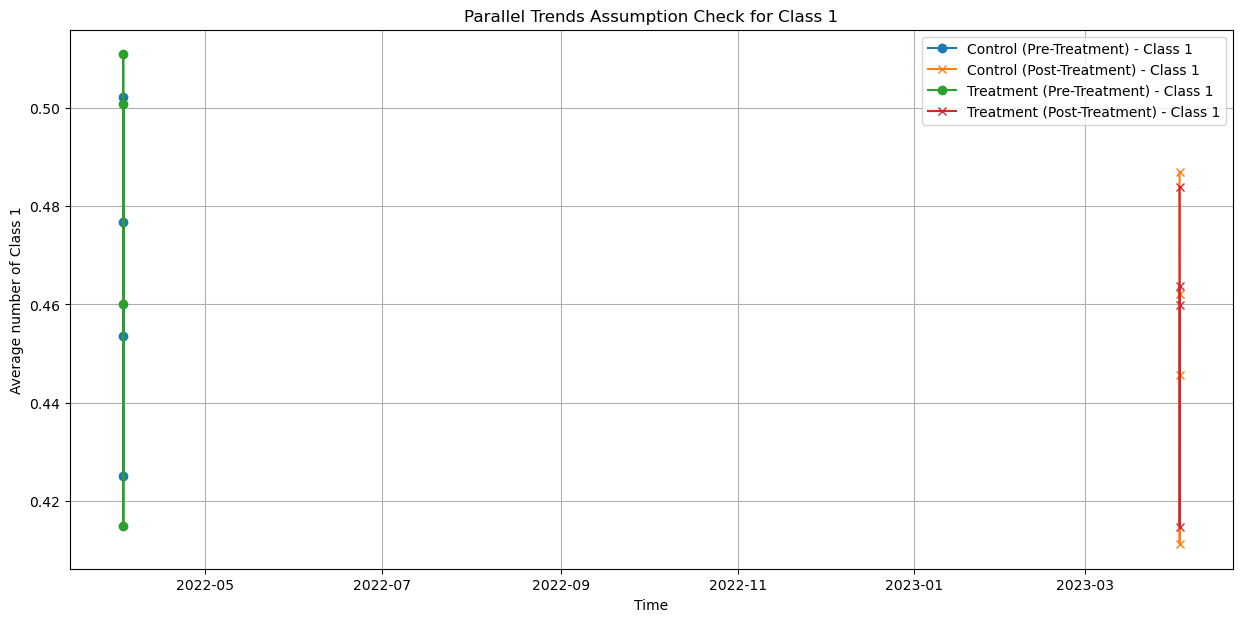

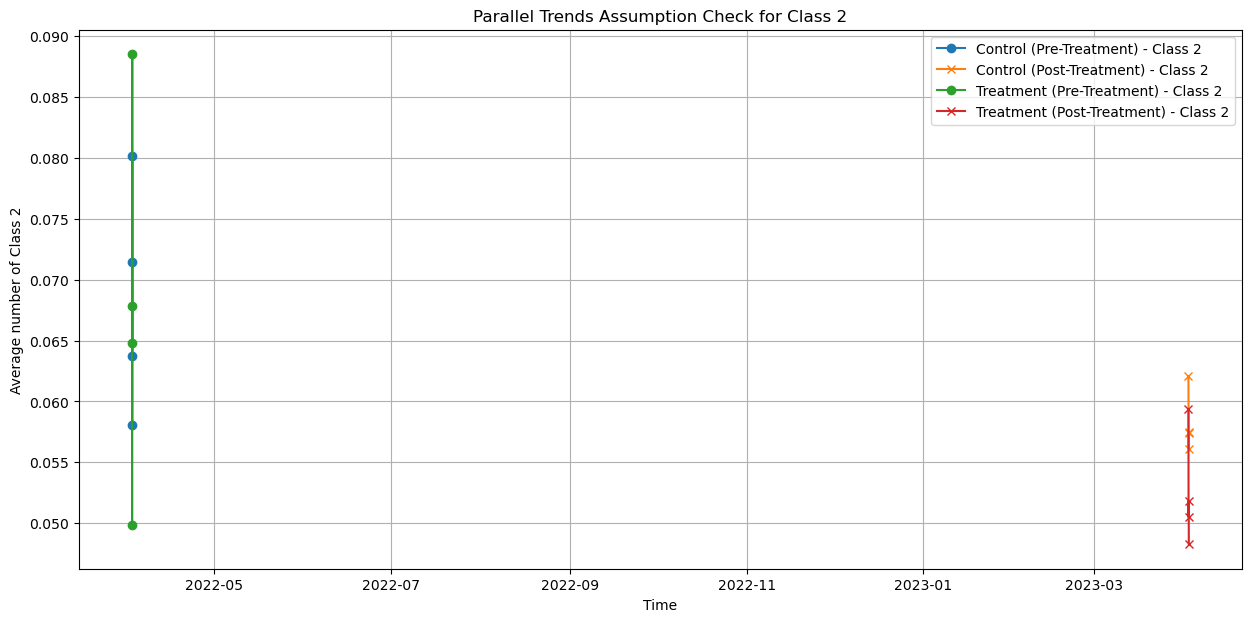

In [60]:
# Aggregate data at the 'time_id' level for each class_int. We calculate the mean because these are binary flags (0/1).
agg_data = panel.groupby(['time_id', 'Treatment', 'period'], as_index=False).agg({'class_int_0': 'mean', 'class_int_1': 'mean', 'class_int_2': 'mean'})

# Now, we'll plot the trends for each class_int. We do this for 'class_int_0', 'class_int_1', and 'class_int_2' to check if any of these metrics show parallel trends.
for class_int in range(3):
    plt.figure(figsize=(15, 7))

    # Plot for control group (where Treatment == 0)
    control_group = agg_data[agg_data['Treatment'] == 0]
    trends_control = control_group.pivot(index='time_id', columns='period', values=f'class_int_{class_int}')
    plt.plot(trends_control.index, trends_control[0], label=f'Control (Pre-Treatment) - Class {class_int}', marker='o')  # period '0' is pre-treatment
    plt.plot(trends_control.index, trends_control[1], label=f'Control (Post-Treatment) - Class {class_int}', marker='x')  # period '1' is post-treatment

    # Plot for treatment group (where Treatment == 1)
    treatment_group = agg_data[agg_data['Treatment'] == 1]
    trends_treatment = treatment_group.pivot(index='time_id', columns='period', values=f'class_int_{class_int}')
    plt.plot(trends_treatment.index, trends_treatment[0], label=f'Treatment (Pre-Treatment) - Class {class_int}', marker='o')
    plt.plot(trends_treatment.index, trends_treatment[1], label=f'Treatment (Post-Treatment) - Class {class_int}', marker='x')

    plt.title(f'Parallel Trends Assumption Check for Class {class_int}')
    plt.ylabel(f'Average number of Class {class_int}')
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.show()

### Interpretation - what to look out for when looking at the graphs (once we use the full dataset)
- Pre-Treatment Trends: The lines for Italy and Germany should move in parallel, showing a similar trajectory
- Divergence Post-Treatment: If the treatment had an effect, the two lines might diverge post GPT
- Consistency Across Metrics: If the same trend is consistent across all metrics, there is stronger validation for the assumption

# 4.Calculate DiD Estimates

In [75]:
import dask.dataframe as dd

In [76]:
# Set up the mean calculations without actually computing them
necessary_columns = ['Treatment', 'period', 'class_int_0', 'class_int_1', 'class_int_2']
panel = panel[necessary_columns]

control_pre_mean = panel[(panel['Treatment'] == 0) & (panel['period'] == 0)].mean()
control_post_mean = panel[(panel['Treatment'] == 0) & (panel['period'] == 1)].mean()
treatment_pre_mean = panel[(panel['Treatment'] == 1) & (panel['period'] == 0)].mean()
treatment_post_mean = panel[(panel['Treatment'] == 1) & (panel['period'] == 1)].mean()

In [77]:
# Compute the means and unpack the results
control_pre, control_post, treatment_pre, treatment_post = dd.compute(
    control_pre_mean, control_post_mean, treatment_pre_mean, treatment_post_mean
)

print("Step 1 Completed: Calculated means for pre-treatment and post-treatment periods.")

Step 1 Completed: Calculated means for pre-treatment and post-treatment periods.


In [78]:
# Calculate the first differences
diff_control = control_post - control_pre
diff_treatment = treatment_post - treatment_pre

print("Step 2 Completed: Calculated the first differences.")

Step 2 Completed: Calculated the first differences.


In [79]:
# Calculate the DiD estimator
did_estimator = diff_treatment - diff_control

print("Step 3 Completed: Calculated the Difference in Differences Estimator.")

Step 3 Completed: Calculated the Difference in Differences Estimator.


In [80]:
# Check and print specific columns, if they exist
class_int_columns = ['class_int_0', 'class_int_1', 'class_int_2']

try:
    print(did_estimator[class_int_columns])
except KeyError:
    print("Some of the specified columns are not present in the 'did_estimator' DataFrame.")

class_int_0    0.008557
class_int_1   -0.003437
class_int_2   -0.005120
dtype: float64


# 5. Fit one Regression per analysed metric

In [81]:
# Create the interaction term between the treatment and the post-treatment period indicator.
panel['treat_post'] = panel['Treatment'] * panel['period']

# Now, set up your regression model. You're interested in the 'treat_post' coefficient,
# as it represents the treatment effect from the DiD setup.

# We will run separate regressions for each class_int as dependent variables.
class_ints = [0, 1, 2]
for class_int in class_ints:
    outcome = f'class_int_{class_int}'
    formula = f'{outcome} ~ Treatment + period + treat_post'
    
    # Fit the regression model using ordinary least squares (OLS)
    model = smf.ols(formula=formula, data=panel).fit()
    print(f"Results for Class {class_int}:")
    print(model.summary())
    print("\n---\n")

# The summary output for each model includes the p-values and the DiD estimator ('treat_post')

Results for Class 0:
                            OLS Regression Results                            
Dep. Variable:            class_int_0   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.112
Date:                Wed, 18 Oct 2023   Prob (F-statistic):           0.000376
Time:                        16:24:53   Log-Likelihood:                -17804.
No. Observations:               24570   AIC:                         3.562e+04
Df Residuals:                   24566   BIC:                         3.565e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4683      0.00

### Analysis for Class 0:
The regression model for Class 0 indicates that the overall R-squared value is quite low at 0.001, suggesting that the model may not explain much of the variance in the data. The F-statistic of 6.112 is statistically significant with a low p-value of 0.000376, indicating that the model as a whole is statistically significant. However, when we look at the individual coefficients, we observe that neither the 'Treatment' nor 'Treat_post' coefficients are statistically significant with p-values of 0.525 and 0.504, respectively. This suggests that there is no significant treatment effect on 'Class 0'. The 'Period' coefficient is statistically significant with a p-value of 0.012, indicating that it may have an effect.

### Analysis for Class 1:
For Class 1, the R-squared value is very low at 0.000, indicating that the model does not explain much of the variance in the data for this class. The F-statistic is 1.770 with a p-value of 0.150, which is not statistically significant. None of the coefficients, including 'Treatment,' 'Period,' and 'Treat_post,' are statistically significant. This suggests that there is no significant treatment effect on 'Class 1'.

### Analysis for Class 2:
The regression model for Class 2 shows a slightly higher R-squared value of 0.001 compared to the previous two classes, but it remains quite low. The F-statistic is statistically significant with a p-value of 0.000133, indicating that the model as a whole is statistically significant. However, when we examine the coefficients, we find that none of them are statistically significant. This suggests that there is no significant treatment effect on 'Class 2'.

### In summary, the regression results for all three classes (0, 1, and 2) indicate that there is no significant treatment effect (as represented by the 'Treat_post' coefficient) in any of these classes. The low R-squared values further suggest that the models do not explain much of the variance in the data, and the F-statistic and individual coefficient p-values support the conclusion that there is no significant impact of the treatment on these classes.